In [49]:
# import workflow.scripts.resources as res_module
import pandas as pd
import geopandas as gpd

In [50]:
from linkingtool.hdf5_handler import DataHandler
import linkingtool.visuals as vis
store=f"../data/store/resources_AB.h5"
datahandler=DataHandler(store)
datahandler.show_tree(store)

Structure of HDF5 file: ../data/store/resources_AB.h5
[Group] boundary
[Group] cells
[Group] clusters
  └─ [Group] clusters/solar
  └─ [Group] clusters/wind
[Group] cost
  └─ [Group] cost/atb
  └─   └─ [Group] cost/atb/bess
  └─   └─ [Group] cost/atb/solar
  └─   └─ [Group] cost/atb/wind
[Group] dissolved_indices
  └─ [Group] dissolved_indices/solar
  └─ [Group] dissolved_indices/wind
[Group] substations
[Group] timeseries
  └─ [Group] timeseries/clusters
  └─   └─ [Group] timeseries/clusters/solar
  └─   └─ [Group] timeseries/clusters/wind
  └─ [Group] timeseries/solar
  └─ [Group] timeseries/wind
[Group] units


# Set Required Args to Activate Modules

In [51]:
# # Iterate over provinces for both solar and wind resources
# resource_types = ['wind'] # , 'solar'
# provinces=['AB']  #'AB','SK','ON','NS'
# for province_code in provinces:
#     for resource_type in resource_types:
#         required_args = {
#             "config_file_path": '../config/config.yaml',
#             "province_short_code": province_code,
#             "resource_type": resource_type
#         }
        
#         # Create an instance of Resources and execute the module
#         resources = res_module.Resources(**required_args)
#         # resources.execute_module()

# Temp tests

In [52]:
boundary=datahandler.from_store('boundary')

<Axes: >

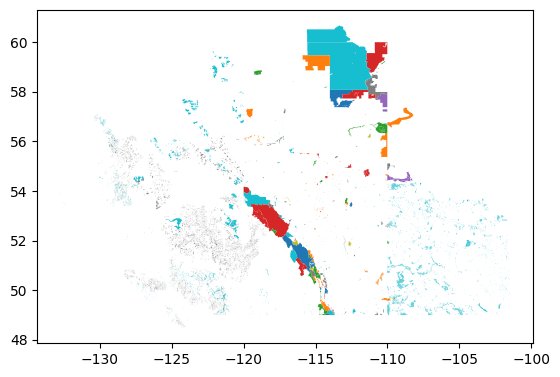

In [53]:
CPCAD=pd.read_pickle('../data/downloaded_data/lands/ProtectedConservedArea_AB.pickle')
CPCAD.plot('NAME_E')

In [54]:
# Filter for Banff and Waterton Lakes National Parks
banff_and_waterton = CPCAD[
    (CPCAD['NAME_E'] == 'Banff National Park Of Canada') | 
    (CPCAD['NAME_E'] == 'Waterton Lakes National Park Of Canada')
]

# Check CRS and reproject if needed
if banff_and_waterton.crs.is_geographic:
    banff_and_waterton = banff_and_waterton.to_crs(epsg=3857)  # Reproject to meters for accurate buffering

# Apply the buffer (e.g., 10 km buffer)
buffered_boundary = banff_and_waterton.geometry.buffer(70000)  # Distance in meters

# Create a new GeoDataFrame with the buffered geometry
buffered_banff = gpd.GeoDataFrame(banff_and_waterton, geometry=buffered_boundary)

# Reproject back to the original CRS if needed
buffered_banff = buffered_banff.to_crs(CPCAD.crs)


In [55]:
cells=datahandler.from_store('cells')
cells=cells[cells['potential_capacity_wind']>7]
cells.to_pickle('Cells_without_regulatory_buffer.pkl')
clusters_wind=datahandler.from_store('clusters/wind').head(10)
clusters_solar=datahandler.from_store('clusters/solar').head(5)

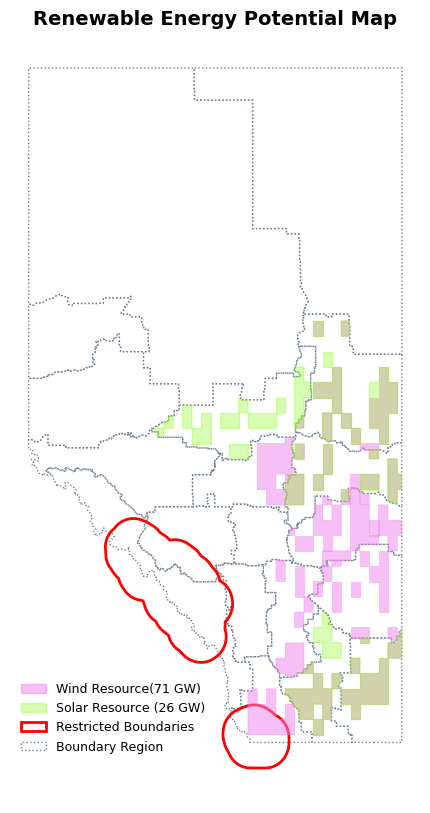

In [56]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# Plot boundary
boundary.plot(ax=ax, edgecolor='slategray', facecolor='none', linewidth=1, linestyle=':')
buffered_banff.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

# Plot wind cells
# cells.plot(ax=ax, edgecolor='violet', facecolor='violet', alpha=0.1, linewidth=0.5)

# Plot wind clusters
clusters_wind.plot(ax=ax, edgecolor='violet', facecolor='violet', alpha=0.5, linewidth=0.5)

# Plot solar clusters
clusters_solar.plot(ax=ax, edgecolor='lawngreen', facecolor='lawngreen', alpha=0.3, linewidth=1)

# Plot project points
# filtered_rod_gdf.plot(ax=ax, marker='o', color=filtered_rod_gdf['Resource Type'].map({'Solar': 'orange', 'Wind': 'navy'}),
#                       markersize=filtered_rod_gdf['Installed Capacity (MW)'] * 0.5, alpha=0.6, edgecolor='black')

# Create custom legend
legend_elements = [
    Patch(facecolor='violet', edgecolor='violet', alpha=0.5, label=f'Wind Resource({int(clusters_wind["potential_capacity"].sum()/1E3)} GW)'),
    Patch(facecolor='lawngreen', edgecolor='lawngreen', alpha=0.3, label=f'Solar Resource ({int(clusters_solar["potential_capacity"].sum()/1E3)} GW)'),
    Patch(facecolor='none', edgecolor='red', linewidth=2, label='Restricted Boundaries'),
    Patch(facecolor='none', edgecolor='slategray', linewidth=1, linestyle=':', label='Boundary Region')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=9, frameon=False, bbox_to_anchor=(0, 0.05))

# Remove axis
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title("Renewable Energy Potential Map", fontsize=14, fontweight='bold')

# Save and show
plt.savefig("static_map.png", dpi=300, bbox_inches='tight')
plt.show()

In [57]:
import folium

# Initialize a Folium map centered at the mean coordinates of the data
# map_center = [cells.geometry.y.mean(), cells.geometry.x.mean()]
m = folium.Map(zoom_start=6, tiles="CartoDB positron")  # Clean, modern map tiles

# Create FeatureGroups for each type of layer
boundary_group = folium.FeatureGroup(name="Boundary Layer")
wind_cells_group = folium.FeatureGroup(name="Wind Cells")
wind_clusters_group = folium.FeatureGroup(name="Wind Clusters")
solar_clusters_group = folium.FeatureGroup(name="Solar Clusters")
points_group = folium.FeatureGroup(name="Project Points")

# Add the boundary GeoDataFrame as a GeoJson layer
boundary_layer = folium.GeoJson(
    boundary,  # This is your boundary GeoDataFrame
    style_function=lambda x: {
        'fillColor': 'None',  # No fill color for the boundary
        'color': 'slategray',  # Border color for boundary regions
        'weight': .1,
        'ls':":",
        'fillOpacity': 0.2  # Transparency level
    }
)
boundary_group.add_child(boundary_layer)

# Add the boundary GeoDataFrame as a GeoJson layer
boundary_layer = folium.GeoJson(
    buffered_banff,  # This is your boundary GeoDataFrame
    style_function=lambda x: {
        'fillColor': 'red',  # No fill color for the boundary
        'color': 'red',  # Border color for boundary regions
        'weight': 3,
        'ls':"-",
        'fillOpacity': 0.2  # Transparency level
    }
)
boundary_group.add_child(boundary_layer)

# Add the MultiPolygon geometries (Wind Cells) directly to the map as GeoJson
for _, row in cells.iterrows():
    folium.GeoJson(
        row.geometry,  # The MultiPolygon geometry
        style_function=lambda x: {
            'fillColor': 'violet',  # Color of the polygon
            'color': 'violet',  # Border color of the polygon
            'weight': .1,  # Border thickness
            'fillOpacity': 0.1  # Fill opacity of the polygon
        },
        tooltip=folium.Tooltip(f"{row['potential_capacity_wind']}<br>Region: {row['Region']}<br> Windspeed_GWA: {round(row['windspeed_gwa'], 2)} m/s")  # Show info on hover
    ).add_to(wind_cells_group)

# Add the MultiPolygon geometries (Wind Clusters) directly to the map as GeoJson
for _, row in clusters_wind.iterrows():
    folium.GeoJson(
        row.geometry,  # The MultiPolygon geometry
        style_function=lambda x: {
            'fillColor': 'violet',  # Color of the polygon
            'color': 'violet',  # Border color of the polygon
            'weight': 0.5,  # Border thickness
            'fillOpacity': 0.5  # Fill opacity of the polygon
        },
        tooltip=folium.Tooltip(f"{row['potential_capacity']}<br>Region: {row['Region']}<br>Rank: {row['Rank']}")  # Show info on hover
    ).add_to(wind_clusters_group)

# Add the MultiPolygon geometries (Solar Clusters) directly to the map as GeoJson
# """ 
for _, row in clusters_solar.iterrows():
    folium.GeoJson(
        row.geometry,  # The MultiPolygon geometry
        style_function=lambda x: {
            'fillColor': 'lawngreen',  # Color of the polygon
            'color': 'lawngreen',  # Border color of the polygon
            'weight': 1,  # Border thickness
            'fillOpacity': 0.3  # Fill opacity of the polygon
        },
        tooltip=folium.Tooltip(f"{row['potential_capacity']}<br>Region: {row['Region']}<br>Rank: {row['Rank']}")  # Show info on hover
    ).add_to(solar_clusters_group)
# """
# Add points to the map without clustering
"""
for _, row in filtered_rod_gdf.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),  # Lat, Long
        radius=row['Installed Capacity (MW)'] * 0.04,  # Scale marker size
        weight=.5,  # Thickness of the border
        color='orange' if row['Resource Type'] == 'Solar' else 'navy',  # Different colors for resource types
        fill=True,
        fill_opacity=0.3,
        popup=folium.Popup(f"<b>{row['Project Name']}</b><br>"
                           f"<b>{row['Resource Type']}</b><br>"
                           f"<strong>Rank: {int(row['Rank'])}</strong> <br>"
                           f"<strong>{int(row['Installed Capacity (MW)'])} MW</strong><br>"
                           f"<i>{row['Region']}</i>", max_width=250),  # Clean and readable popup
    ).add_to(points_group)
"""
# Add all feature groups to the map
m.add_child(boundary_group)
m.add_child(wind_cells_group)
m.add_child(wind_clusters_group)
m.add_child(solar_clusters_group)
m.add_child(points_group)
#
# Add a sleek legend manually with modern style
legend_html = """
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 160px; 
background-color: rgba(255, 255, 255, 0.7); border:2px solid #ccc; z-index:9999; font-size:14px; 
border-radius: 10px; padding: 10px;">
  <b>Legend</b><br>
  <i style="color:orange;">●</i> Solar<br>
  <i style="color:navy;">●</i> Onshore Wind<br>
  <i style="color:violet;">●</i> Wind Clusters<br>
  <i style="color:red;">●</i> Park Boundaries<br>
  <i style="color:maroon;">■</i> Boundary Region<br>  <!-- For boundary regions -->
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control to toggle visibility of the layers
folium.LayerControl().add_to(m)

# Save and display the map
m.save('AB_2024.html')
m
